# Introduction
This notebook is aimed to host data from the Titanic dataset for Kaggle's competition. We aimed to analyze and predict which passengers from the Titanic will survive.

### Imports
Import libraries establish settings.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis
import pingouin as pg
import scipy.stats as stats
from scipy.stats import norm

# set matplotlib parameters


C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Analysis/Modeling

## Import data

In [2]:
# path to the file
path = "train.csv"

# import csv
train = pd.read_csv(path)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing values

Let's explore what kind of data the Dataset holds.

We have numerical and categorical data. Most of the columns contains non-null values, although we can see that missing values are found in Age (177), Cabin (687) and some in Embarked (2) columns.

For this, we would try to adopt some strategies. 

* First, we will first explore if there are differences between Passenger Class in Age. In case there are statistically significant differences, we will impute the NaN values in Age  with the mean of its corresponding class group.


* Second, it could be possible that NaN values for Cabin could correspond to those in third class that do not have a cabin assigned. In any case, we will first see if for null-values in Cabin we only have "3" as unique value.


* Third, we will try to find some information in the Dataset to impute missing values in Embarked. If we do not find any convincing information, we will try to search on the internet to have a better understanding of the data.

In [3]:
# DataFrame information
train.info()

# missing values in Age, Cabin and Embarked
pd.DataFrame(data=train[["Age", "Cabin", "Embarked"]].isnull().sum(), columns=["Missing values"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,Missing values
Age,177
Cabin,687
Embarked,2


### Missing values in Age

First, let's explore descriptive statistics for numerical data. We can see that we have a minimum Age of 0.42, which should correspond to the age of an infant. The maximum value is 80, so everything normal until here. The standard deviations also seems reasonable as the mean and median.


Also, we see that Pclass is between 1 and 3, so no unexpected values in that column. 


Interestingly, we have a minimum Fare value of zero, so that means that there are some people that did not pay for his/her ticket. We standard deviation is quite high, but this is because we have a huge range of values if we take a look to the minimum and maximum values. We would expect there values to be quite spread.

In [4]:
# descriptive statistics for numeric variables
display(train[["Age", "Fare", "Pclass"]].describe())

# unique values in Pclass
print("We have these unique values in Pclass column:", sorted(list(train["Pclass"].unique())))

,Age,Fare,Pclass
count,714.000000,891.000000,891.000000
mean,29.699118,32.204208,2.308642
std,14.526497,49.693429,0.836071
min,0.420000,0.000000,1.000000
25%,20.125000,7.910400,2.000000
50%,28.000000,14.454200,3.000000
75%,38.000000,31.000000,3.000000
max,80.000000,512.329200,3.000000


We have these unique values in Pclass column: [1, 2, 3]


Now, we will test if there are statistically significant differences in Age based on Passenger Class. We will use Analysis of Variance. From the ANOVA, we see that there is a statistically significant difference, so we should replace NaN values for each Passenger Class with the mean of its corresponding class.

In [5]:
# descriptive statistics by Pclass
display(train.groupby(["Pclass"])["Age"].describe().T.rename(columns={1: 'First class', 2: 'Second class', 3: 'Third class'}))

# ANOVA
pg.anova(data=train[["Pclass", "Age"]], dv="Age", between="Pclass", detailed=False)

Pclass,First class,Second class,Third class
count,186.000000,173.000000,355.000000
mean,38.233441,29.877630,25.140620
std,14.802856,14.001077,12.495398
min,0.920000,0.670000,0.420000
25%,27.000000,23.000000,18.000000
50%,37.000000,29.000000,24.000000
75%,49.000000,36.000000,32.000000
max,80.000000,70.000000,74.000000


,Source,ddof1,ddof2,F,p-unc,np2
0,Pclass,2,711,57.443484,7.487984e-24,0.139107


From the distribution of age we can see that older ages are more common along the first class. This makes sense, as in the first class we should have found people from a high socioeconomic background, hence they were able to afford a better lifestyle and better health care. On the other hand, we can see that the upper boundary of the interquartile range is around 55 years of age, and a few outliers above that.

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1282: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1286: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


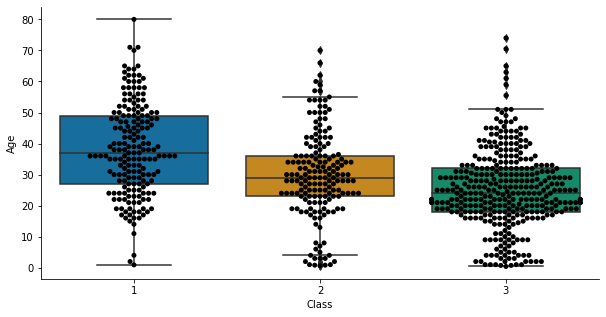

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=train["Pclass"], y=train["Age"], palette="colorblind")
sns.swarmplot(x=train["Pclass"], y=train["Age"], color="black")
ax.set_xlabel("Class")
sns.despine()

### Exploring Fare

As we said before, we have quite spread values in Fare but just because there are some outliers above the 1.5 times the interquartile range (IQR). Exploring the boxplot se can see that most of the values are inside the IQR and, and some between the upper and lower value of 1.5 times the IQR. We can consider removing these values, but it could also be variability in the data, and also be related to survival (higher classes could have been prioretized). Let's see how the thing looks for each class. 

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


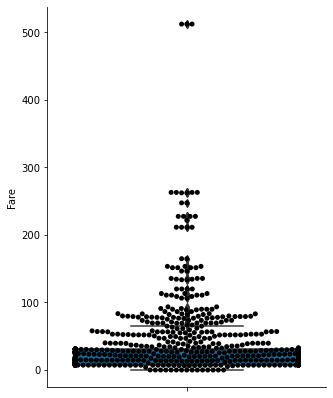

In [7]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(y=train["Fare"], palette="colorblind")
sns.swarmplot(y=train["Fare"], color="black")
sns.despine()

As expected, most of the biggest outliers belong to first class. Although, we can also see some outliers for second and third class. There are also some third class passengers that paid the same Fare that First and Second class passengers. How can be this possible? It seems weird that Third class were paying the same Fares to be in the lowest class.

As an option, we can create a Custom Transformer that computes the lower and upper boundary of the 1.5 times the IQR, and include it in a Pipeline or not to fit the model, and compare how the model work with and without outliers.

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 71.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


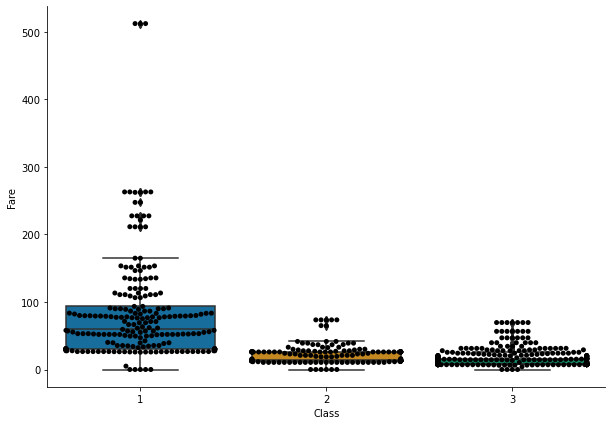

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x=train["Pclass"], y=train["Fare"], palette="colorblind")
sns.swarmplot(x=train["Pclass"], y=train["Fare"], color="black")
ax.set_xlabel("Class")
sns.despine()

### Missing values in Cabin (create Custom Transformer for this)

Exploring the data, we have discovered that we cannot make an automatic replacement for Cabin, as we have NaN values not only for third class, but for first and second too. Once discovered this, we will replace NaN values for in Cabin with "Unspecified" independently of the Class, this could also be informative. 

Searching on the internet, third class cabins were located at the lower levels of the ship, while second and first class were located in the upper floors. It seems that Cabins in the Titanic were not evenly distributed by floors, as different class Cabins could be located on the same floor. We can also see that there is a T boat deck, and some 1st class cabins were located at E deck.

In [9]:
# unique values of Pclass for missing values in Cabin
train[train["Cabin"].isnull()]["Pclass"].unique()

print("Let's check how many Decks occupied each class:")
display(train.groupby(["Pclass"])["Deck"].unique())

print("\nThere is one 1st class passengger on Deck T:")
display(train[train["Deck"] == "T"])

Let's check how many Decks occupied each class:


KeyError: 'Column not found: Deck'

### Missing values in Embarked

We couldn't gather any additional information based on Ticket or Cabin to replace missing values in Embarked. However, looking for information on the internet we found that Miss Amelie Icard traveled in the Titanic as maid to Mrs. Martha Evelyn, and they embarked in Southampton, so we will replace these missing values with an "S" for Southampton.

In [ ]:
# rows for missing values in Embarked
display(train[train["Embarked"].isnull()])

# replace Embarked missing values
train.loc[(train["Cabin"] == "B28"), "Embarked"] = "S"
train[train["Cabin"] == "B28"]

## Feature engineering (create Custom Transformer for this)

### New ticket features based on Ticket information

The Ticket feature contains a lot of interesting information. We will try to extract more useful features splitting the ticket data into two, one variable including the first letters of the ticket as it seems to code something more specific. The other will contain the rest of the ticket information, mainly as numerical data.

In [10]:
# empty DataFrame to contain the splitted information
empty = pd.DataFrame()

# split the data based on white spaces
empty = train["Ticket"].str.split(pat=' ', n=1, expand=True)

# rename the columns
empty.rename({0: "Ticket_L", 1: "Ticket_N"}, axis=1, inplace=True)

# merge into the train DataFrame the splitted data
train = train.merge(empty, left_on=train.index, right_on=empty.index).drop(columns='key_0')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None


### New Deck and Section features based on Cabin


Looking for information on the internet, we have found that the letter of the Cabin designated the range of floors that covered. So in order to simplify this feature, we will also store the deck letter in a separate column. Exploring values in third class we have discovered that there are also some passengers that have a double letter on their Cabin, like Passenger 716 (Mr. Peter Andreas) who is in Cabin "F G73". It could be possible that he was located on F Deck, but section G. In this case we will separate this as a new feature, we will create a column for Section.

First, let's create a regex expression just to extract the first and second letter of Cabin. The first letter will indicate the Deck and the second the Section. In case we do not have a Cabin assigned to the passenger, it will be filled with NaN.

In [11]:
def deck_section(df):
    """
    Extract Section letter from those cases in which Cabin
    indicated Deck and Section. If there is no Section letter,
    the Section value will be fill with the Deck value.
    """
    # extract the Deck from Cabin
    df["Deck"] = df["Cabin"].str.slice(start=0, stop=1)
    # create regex pattern
    pattern = r"^(\D)(\s)(\D)"
    # extract the letters where the expression is matched, otherwise NaN. Rename columns so they are informative
    t_df = df["Cabin"].str.extract(pattern).rename(columns={0: "Deck", 1: "whitespace", 2: "Section"})
    # check case 715 where there is one letter for Deck and another for Section
    # concatenate DataFrame and Series
    df = pd.concat([df, t_df["Section"]], axis=1, join="inner")
    # where section is null, replace with deck value
    df["Section"] = np.where(df["Section"].isnull(), df["Deck"], df["Section"])
    
    return df

train = deck_section(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None,NaN,NaN


### New title feature based on Name

We are going to extract the title of each person and store it as a new feature.

In [12]:
# replace non alphanumeric characters with whitespaces
names = train["Name"].str.replace('[^a-zA-Z\s\d:]', ' ').str.split(pat=' ', n=-1, expand=True)
# temporary column names
names.columns = ["col1", "col2", "col3", "col4", "col5", "col6", "col7", "col8", "col9", "col10", "col11", "col12", "col13",
                  "col14", "col15", "col16", "col17", "col18"]
# columns with most of the titles
print("Titles found and stored in column three:", names["col3"].unique())
print("Titles found and stored in column four:", names["col4"].unique())

# store titles in a list
titles = ["Mr", "Mrs", "Miss", "Master", "Don", "Rev", "Dr", "Mme", "Ms", 
          "Major", "Mlle", "Col", "Capt", "Lady", "Sir", "Countess", "Count",
          "Jonkheer"]
print(titles)

# store titles in a new column Titles
train["Title"] = "None"
for title in titles:
    train.loc[train["Name"].str.contains(title), "Title"] = title
    
train.head()

Titles found and stored in column three: ['Mr' 'Mrs' 'Miss' 'Master' '' 'Don' 'Rev' 'hoef' 'Dr' 'Castellana' 'Mme'
 'Ms' 'Major' 'Manent' 'Mlle' 'Col' 'Capt' 'the' 'Jonkheer' 'More']
Titles found and stored in column four: ['' 'Mrs' 'Miss' 'Master' 'Mr' 'Lady' 'Sir' 'Dr' 'Col' 'Countess']
['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Mlle', 'Col', 'Capt', 'Lady', 'Sir', 'Countess', 'Count', 'Jonkheer']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,NaN,NaN,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,NaN,NaN,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None,NaN,NaN,Mr


### New passengers number by ticket code

As many people have the same ticket code, we will extract the number of persons with the same ticket code. I believe this could be informative, as maybe families would have been prioritized for the lifeboats. In the same direction, we will extract the number of persons assigned to the same cabin.

In [13]:
# dictionary with number of passengers with the same ticket code
dict_numb_pass_ticket = train.groupby(["Ticket"])["PassengerId"].count().to_dict()

# dictionary with number of passengers in the same cabin
dict_numb_pass_cabin = train.groupby(["Cabin"])["PassengerId"].count().to_dict()

# map into the dataframe
train["Passengers_Ticket"] = train["Ticket"].map(dict_numb_pass_ticket)
train["Passegers_Cabin"] = train["Cabin"].map(dict_numb_pass_cabin)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section,Title,Passengers_Ticket,Passegers_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,NaN,NaN,Mr,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C,Mrs,1,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,NaN,NaN,Miss,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C,Mrs,2,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None,NaN,NaN,Mr,1,NaN


We still have quite a lot of missing values for "Cabin" in 3rd class passengers, so both Deck and Section will be also empty. Looking for information most of the 3rd class cabins were located in F deck and some in G deck, so we can fill the missing values in Cabin for 3rd class passengers with F for Deck and Section. This is also the most common value of the non missing values in 3rd class as we can see in the plot. Interestingly, we also found that the Titanic was designed to avoid classed to mix, with gates usually closed for this purpose.

For 2nd class, most of the Cabins were located at E deck, so we will replace missing values for this class with an E for Deck and Section. In the plot we see that the most common Deck for 2nd class is D and E.

Finally, for 1st class the most common value is C deck, folowed by B.

In general, we will create a Custom Imputer to replace missing values in Deck and Section with the Deck with the higher number of passengers by Class.


Number of passengers by Class with missing values in Cabin:


,Pclass,Cabin
0,1,40
1,2,168
2,3,479


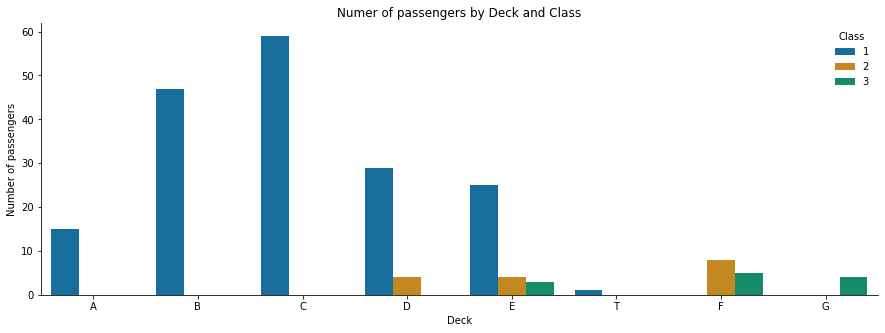

In [14]:
print("\nNumber of passengers by Class with missing values in Cabin:")
display(pd.DataFrame(data=train.groupby(["Pclass"], as_index=False)["Cabin"].apply(lambda x: x.isnull().sum())))

missing_class_deck = train.groupby(["Pclass", "Deck"], as_index=False)["PassengerId"].count()
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="Deck", y="PassengerId", hue="Pclass", data=missing_class_deck, palette="colorblind")
sns.despine()
ax.set_ylabel("Number of passengers")
ax.set_title("Numer of passengers by Deck and Class")
ax.legend(title="Class", frameon=False)
plt.show()

## Feature distribution

Now, it time to check that the variables are normally distributed, as they can have an impact over model performance, unless we use Tree based models. First, we will explore the distribution of Fare. The distribution show a positive skewness.


Descriptives for Age and Fare


,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200



Descriptives for Fare by Class


Pclass,1,2,3
count,216.000000,184.000000,491.000000
mean,84.154687,20.662183,13.675550
std,78.380373,13.417399,11.778142
min,0.000000,0.000000,0.000000
25%,30.923950,13.000000,7.750000
50%,60.287500,14.250000,8.050000
75%,93.500000,26.000000,15.500000
max,512.329200,73.500000,69.550000


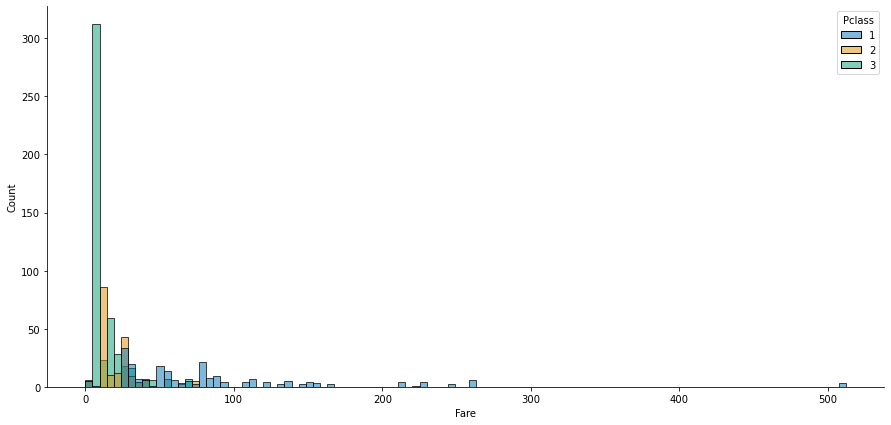

In [15]:
# Age and Fare in the whole sample
print("\nDescriptives for Age and Fare")
display(train[["Age", "Fare"]].describe())

# Fare by class
print("\nDescriptives for Fare by Class")
display(train.groupby(['Pclass'])["Fare"].describe().T)

# plot the distribution of Fare
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data=train, x="Fare", hue="Pclass", palette="colorblind")
sns.despine()
plt.show()

If we zoom into values in the range between 0 and 100, we see that there are First class prices similar to Third class! And the same happens with Second class. Let's print some rows to check this out, specifically for prices below 20$.

Wow, there are 216 tickets priced below 20$ for First class, 184 for Second class and 491! for Third class... how is it possible that Third class paid the same that First class? Could this be something like a group discount? Let's explore it, maybe people with the same ticket have the same price...

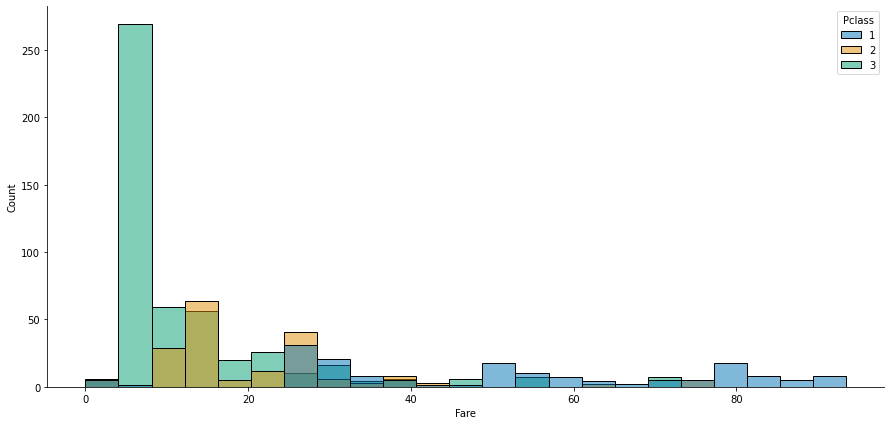

,Pclass,Fare
0,1,216
1,2,184
2,3,491


In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data=train[train["Fare"] < 100], x="Fare", hue="Pclass", palette="colorblind")
sns.despine()
plt.show()

pd.DataFrame(train.groupby(["Pclass"])["Fare"].count()).reset_index()

We can see that those with the same Ticket number have the same "Fare" associated, so this is going to be quite challenging, as it seem unreasonable that First class passengers paid the same price as Third class passengers. 

In [60]:
tickets_numbers = pd.DataFrame(train[train["Fare"] < 20]["Ticket"].value_counts() > 1).reset_index()
tickets_more_than_once = tickets_numbers.loc[tickets_numbers["Ticket"] == True]["index"].to_list()
train.loc[train["Ticket"].isin(tickets_more_than_once)].sort_values(by="Ticket")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.00,NaN,S,239853,None,NaN,NaN
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.00,NaN,S,239853,None,NaN,NaN
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.00,NaN,S,239853,None,NaN,NaN
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.50,NaN,S,250644,None,NaN,NaN
272,273,1,2,"Mellinger, Mrs. (Elizabeth Anne Maidment)",female,41.0,0,1,250644,19.50,NaN,S,250644,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.70,G6,S,PP,9549,G,G
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.50,NaN,S,S.O./P.P.,3,NaN,NaN
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.50,E77,S,S.O./P.P.,3,E,E
142,143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.85,NaN,S,STON/O2.,3101279,NaN,NaN


In [31]:
def normality_tests(df, vars_list):
    
    """
    Checks normality assumptions ussing Kolmogorov-Smirnov (K-S), Shapiro-Wilks (S-W) 
    and D'Agostino-Pearson (D-P).
    
    Input:
        df: DataFrame with data
        vars_list: list of dependent variables to check for normality in the DataFrame.
        
    Output:
        df_NormalityCheck: DataFrame with each dependent variable in a row. Statistics and
                           p-values for each dependent variable for each test.
    """
    
    normality_tests = {'K-S': stats.kstest, 'S-W': stats.shapiro, 'D-P': stats.normaltest}
    normality_dfs = []
    for normal_name, normal_module in normality_tests.items():
        if normal_name == 'K-S':
            df_NormalityCheck = pd.DataFrame(dict([(dv, normal_module(df[dv].dropna(), 'norm')) \
                                                   for dv in vars_list])).rename({0: normal_name, 1: 'p-value ' + 
                                                                                  str(normal_name)}).T
            normality_dfs.append(df_NormalityCheck)
        else:
            df_NormalityCheck = pd.DataFrame(dict([(dv, normal_module(df[dv].dropna())) \
                                                   for dv in vars_list])).rename({0: normal_name, 1: 'p-value ' + 
                                                                                  str(normal_name)}).T
            normality_dfs.append(df_NormalityCheck)
    
    df_NormalityCheck = pd.concat(normality_dfs, axis = 1, sort = False).round(4)
    
    return df_NormalityCheck

In [32]:
def plot_dist(df, dv_list=None, transformation=None):
    """
    Plot distribution of data. If required, a transformation
    of the data could be applied.
    
    Input:
        df: DataFrame
        dv_list: list of variables to be plotted.
        trasnformation (numpy): transformation that wants
                                to be applied to the data.
    Output:
        Distribution plot and probability plot of each variable.
    """
    
    
    if dv_list == None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
        
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df, fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df.dropna(), plot=ax[1])
        plt.show()
        
    elif dv_list != None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
            
        for dv in dv_list:
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
            stats.probplot(df[dv].dropna(), plot=ax[1])
            plt.show()

### Original distribution

Age seems to have a almost normal distribution, we will try to transform it but this is almost a good approximation to normality. On the other hand, Fare is basically not normally distributed, so we will try to apply some transformations.

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.9650,0.0,0.9815,0.0,18.1050,0.0001
Fare,0.9831,0.0,0.5219,0.0,904.5873,0.0000


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


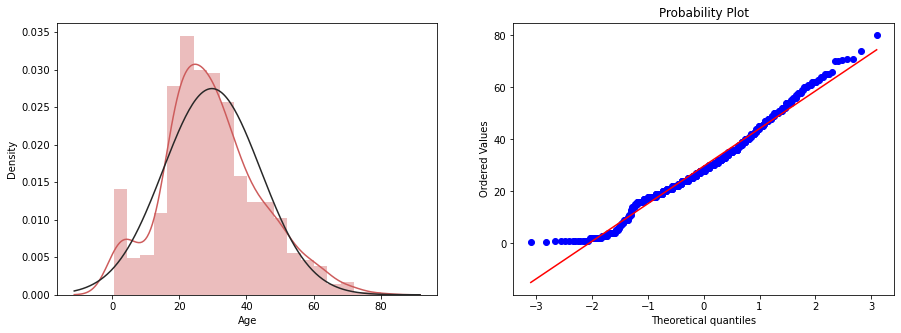

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


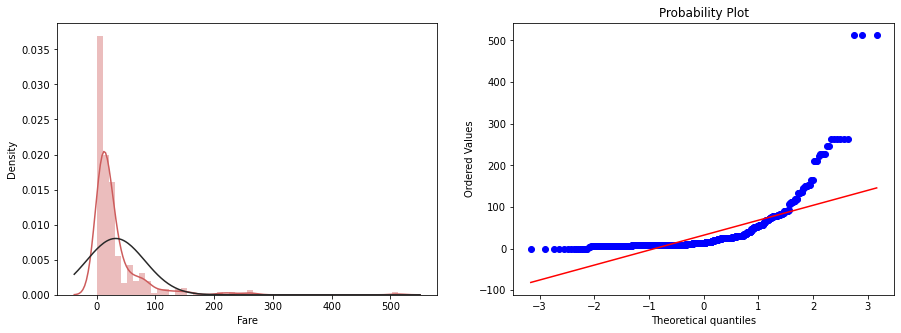

In [36]:
# list of numerical variables
numerical_vars = ["Age", "Fare"]

# normality tests
display(normality_tests(train, numerical_vars))

# plot distribution
plot_dist(train, dv_list=numerical_vars, transformation=None)

### Logarithmic transformation

Log + 1 to avoid zero values

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.9160,0.0,0.8286,0.0,278.6549,0.0
Fare,0.9574,0.0,0.9152,0.0,39.8639,0.0


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


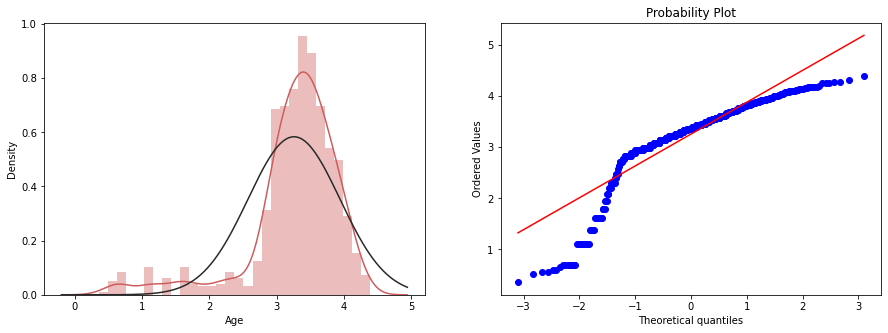

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


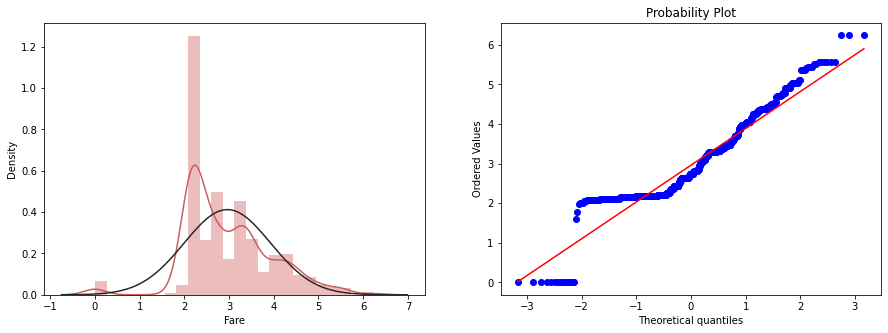

In [40]:
train_log = np.log(train[numerical_vars] + 1)
display(normality_tests(train_log, numerical_vars))
plot_dist(df=train_log, dv_list=numerical_vars, transformation=None)

### Logarithmic base 10 transformation

Log + 1 to avoid zero values

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.7808,0.0,0.8286,0.0,278.6549,0.0
Fare,0.7884,0.0,0.9152,0.0,39.8639,0.0


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


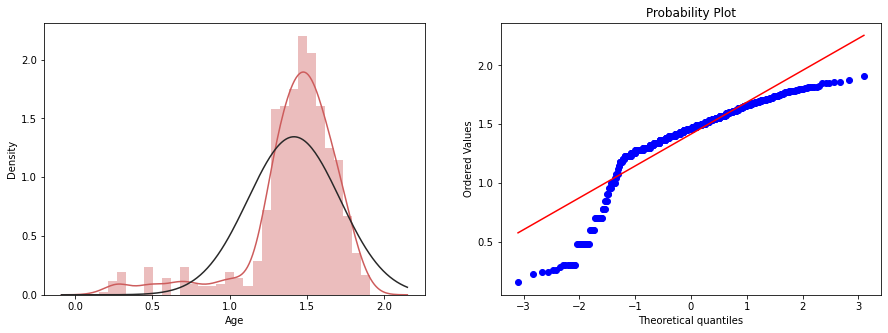

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


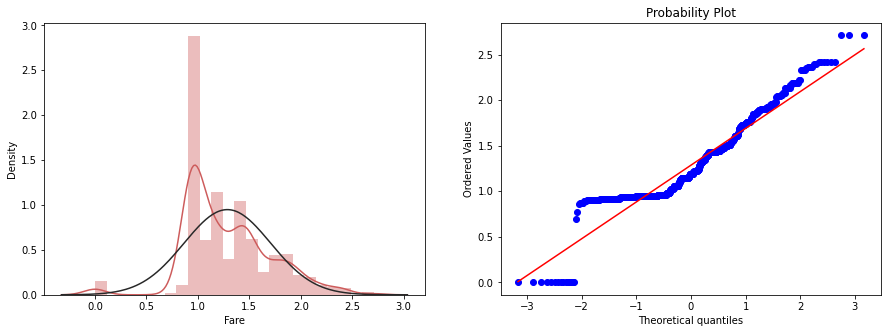

In [37]:
train_log10 = np.log10(train[numerical_vars] + 1)
display(normality_tests(train_log10, numerical_vars))
plot_dist(df=train_log10, dv_list=numerical_vars, transformation=None)

### Square 

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.9804,0.0,0.8452,0.0,236.1716,0.0
Fare,0.9832,0.0,0.1737,0.0,1580.9284,0.0


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


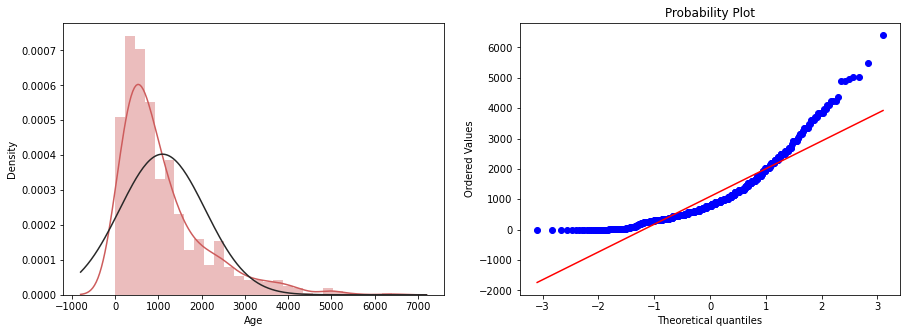

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


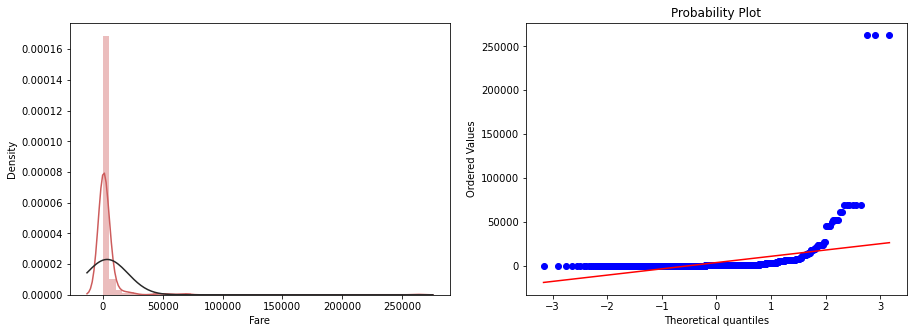

In [39]:
df_square = train[["Age", "Fare"]].apply(np.square)
display(normality_tests(df_square, numerical_vars))
plot_dist(df=df_square, dv_list=numerical_vars, transformation=None)

### Power Transformation (Yeo-Johnson)

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.0632,0.0063,0.9869,0.0,0.8082,0.6676
Fare,0.1507,0.0000,0.9121,0.0,32.6459,0.0000


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


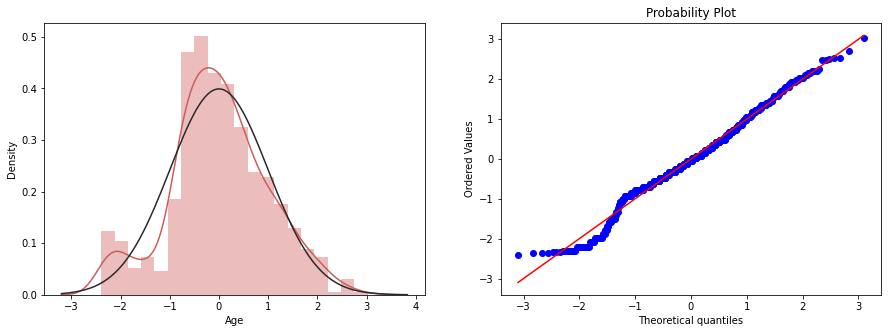

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


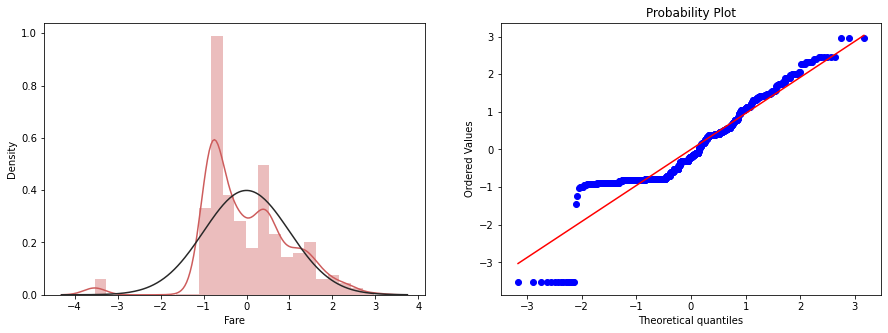

In [41]:
from sklearn.preprocessing import PowerTransformer

PT_trans = PowerTransformer()
df_power = PT_trans.fit_transform(train[numerical_vars])
df_power = pd.DataFrame(data=df_power, columns=["Age", "Fare"])
display(normality_tests(df_power, numerical_vars))
plot_dist(df=df_power, dv_list=numerical_vars, transformation=None)

### Square root

,K-S,p-value K-S,S-W,p-value S-W,D-P,p-value D-P
Age,0.9352,0.0,0.9609,0.0,57.6222,0.0
Fare,0.9747,0.0,0.7878,0.0,406.4482,0.0


C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


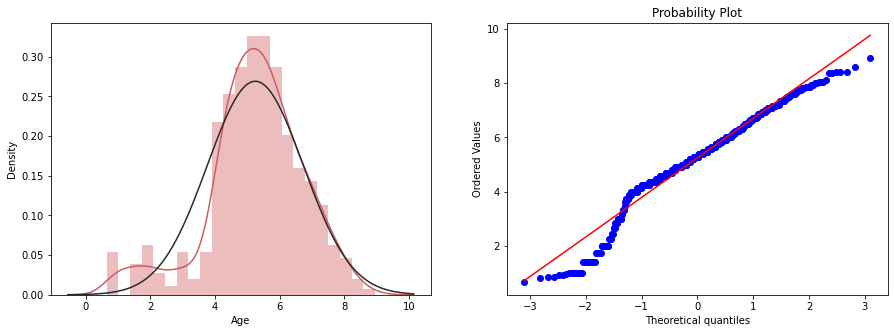

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


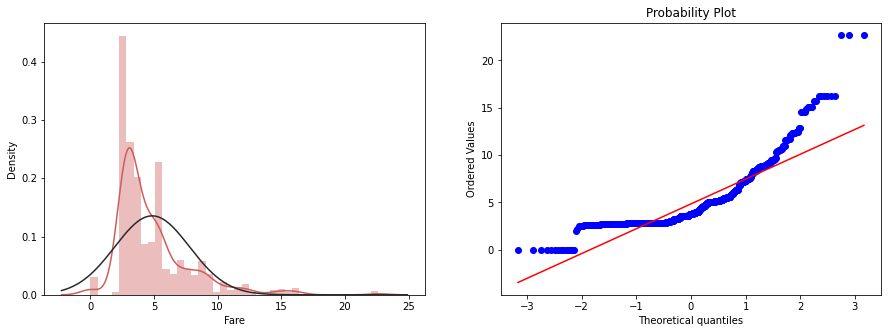

In [42]:
df_sqrt = train[["Age", "Fare"]].apply(np.sqrt)
display(normality_tests(df_sqrt, numerical_vars))
plot_dist(df=df_sqrt, dv_list=numerical_vars, transformation=None)

After all this process, we have seen that Age is almost normally distributed when the original values are considered, as transformations did not improve the distribution.


For Fare, we will use the Power Transformation considered in sklearn, as it will be easier to implement. Although, we should also consider logarithmic base 10 (+1) transformation, in case we want to modify some transformers in out Pipeline.

## StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

SS_scaler = StandardScaler()
df_scaled = SS_scaler.fit_transform(train[["Age", "Fare"]])
df_scaled = pd.DataFrame(data=df_scaled, columns=["Age", "Fare"])
df_scaled

## Custom Transformers

Let's create a the Custom Transformers, so we can apply it to the test dataset in a Pipeline. We can always check model fitting applying only certain transformers.

### Age Imputer

In [118]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.mean_age_by_class = {}
        print("Transforming data. In the AgeImputer init method: ")

    def fit(self, X, y=None):
        self.mean_age_by_class = X.groupby(["Pclass"])["Age"].mean()

        return self

    def transform(self, X, y=None):
        # apply values based on dictionaries 
        for pclass, mean_age in self.mean_age_by_class.items():           
            X.loc[((X["Age"].isnull()) & (X["Pclass"] == pclass)), "Age"] = mean_age
              
        return X

### Deck-Section Imputer

In [84]:
class DeckSectionImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.most_common_deck_first_class = {}
        self.most_common_deck_second_class = {}
        self.most_common_deck_third_class = {}
        print("Transforming data. In the DeckSectionImputer init method: ")

    def fit(self, X, y=None):
        temp_X = X.groupby(["Pclass", "Deck"], as_index=False)["PassengerId"].count()
        self.most_common_deck_first_class = temp_X["Deck"].loc[temp_X["PassengerId"] == temp_X.loc[df["Pclass"] == 1]["PassengerId"].max()].values[0]
        self.most_common_deck_second_class = temp_X["Deck"].loc[temp_X["PassengerId"] == temp_X.loc[df["Pclass"] == 2]["PassengerId"].max()].values[0]
        self.most_common_deck_third_class = temp_X["Deck"].loc[temp_X["PassengerId"] == temp_X.loc[df["Pclass"] == 3]["PassengerId"].max()].values[0]

        return self

    def transform(self, X, y=None):
        # first, second and third class Cabin null values replace in Deck
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 1)), "Deck"] = self.most_common_deck_first_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 2)), "Deck"] = self.most_common_deck_second_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 3)), "Deck"] = self.most_common_deck_third_class
        
        # first, second and third class Cabin null values replace in Section
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 1)), "Section"] = self.most_common_deck_first_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 2)), "Section"] = self.most_common_deck_second_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 3)), "Section"] = self.most_common_deck_third_class
        
        return X

### Ticket new features transformer

### Title and number of persons per cabin transformer

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here